In [1]:
import os, random
import numpy as np
import pandas as pd
from pathlib import Path


In [2]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

# ========= 1) Load =========
CSV_PATH = Path("UCI_Credit_Card.csv")
df = pd.read_csv(CSV_PATH)
if "default.payment.next.month" in df.columns:
    df = df.rename(columns={"default.payment.next.month": "target"})
df["target"] = df["target"].astype(int)


In [3]:
# ========= 2) Feature Engineering =========

bill_cols = [f"BILL_AMT{i}" for i in range(1, 7)]
pay_cols  = [f"PAY_AMT{i}"  for i in range(1, 7)]
paystat   = [f"PAY_{i}"     for i in range(0, 7)]  # PAY_0..PAY_6

def slog1p(x):
    import numpy as np
    return np.sign(x) * np.log1p(np.abs(x))

def engineer_features(frame: pd.DataFrame) -> pd.DataFrame:
    X = frame.copy()

    # --- Utilization & Pay ratio (per month) ---
    for i in range(1, 7):
        X[f"util_{i}"] = (X[f"BILL_AMT{i}"] / X["LIMIT_BAL"]) \
            .replace([np.inf, -np.inf], 0.0).fillna(0.0).clip(0, 5)
        denom = X[f"BILL_AMT{i}"].abs().clip(lower=1.0)
        X[f"pay_ratio_{i}"] = (X[f"PAY_AMT{i}"] / denom).clip(0, 5)

    util_cols = [f"util_{i}" for i in range(1,7)]
    payr_cols = [f"pay_ratio_{i}" for i in range(1,7)]

    # --- Level & dispersion ---
    X["bill_mean"] = X[bill_cols].mean(axis=1)
    X["bill_std"]  = X[bill_cols].std(axis=1).fillna(0.0)
    X["pay_mean"]  = X[pay_cols].mean(axis=1)
    X["pay_std"]   = X[pay_cols].std(axis=1).fillna(0.0)

    # --- Trends (recent minus past) ---
    X["bill_trend_1_3"] = X["BILL_AMT1"] - X["BILL_AMT3"]
    X["bill_trend_1_6"] = X["BILL_AMT1"] - X["BILL_AMT6"]
    X["pay_trend_1_3"]  = X["PAY_AMT1"] - X["PAY_AMT3"]
    X["pay_trend_1_6"]  = X["PAY_AMT1"] - X["PAY_AMT6"]

    # --- Payment gaps (unpaid part) ---
    for i in range(1,7):
        X[f"gap_{i}"] = (X[f"BILL_AMT{i}"] - X[f"PAY_AMT{i}"]).clip(lower=0)
    gap_cols = [f"gap_{i}" for i in range(1,7)]
    X["gap_mean"]       = X[gap_cols].mean(axis=1)
    X["gap_ratio_mean"] = (X["gap_mean"] / X["LIMIT_BAL"]) \
        .replace([np.inf,-np.inf],0).fillna(0.0).clip(0,5)

    # --- Aggregates & consistency ---
    X["util_mean"]       = X[util_cols].mean(axis=1)
    X["util_var"]        = X[util_cols].var(axis=1).fillna(0.0)
    X["pay_ratio_mean"]  = X[payr_cols].mean(axis=1)
    X["pay_ratio_var"]   = X[payr_cols].var(axis=1).fillna(0.0)
    X["max_util"]        = X[util_cols].max(axis=1)
    X["recent_util_mean"]= X[["util_1","util_2"]].mean(axis=1)
    X["old_util_mean"]   = X[["util_5","util_6"]].mean(axis=1)
    X["util_recent_vs_old"] = X["recent_util_mean"] - X["old_util_mean"]

    X["recent_payr_mean"]= X[["pay_ratio_1","pay_ratio_2"]].mean(axis=1)
    X["old_payr_mean"]   = X[["pay_ratio_5","pay_ratio_6"]].mean(axis=1)
    X["payr_recent_vs_old"] = X["recent_payr_mean"] - X["old_payr_mean"]

    X["total_bill"]      = X[bill_cols].sum(axis=1)
    X["total_pay"]       = X[pay_cols].sum(axis=1)
    X["total_pay_ratio"] = (X["total_pay"] / X["total_bill"].abs().clip(lower=1.0)).clip(0, 5)
    X["pay_over_limit"]  = (X["total_pay"] / X["LIMIT_BAL"].clip(lower=1.0)).clip(0, 5)

    # --- Delinquency flags ---
    # handle cases where some PAY_* columns (e.g., PAY_1) may be missing
    pay_present = [c for c in paystat if c in X.columns]
    if len(pay_present) > 0:
        X["max_delinq"] = X[pay_present].max(axis=1)
        X["late_any"] = (X[pay_present].gt(0).any(axis=1)).astype(int)
        X["severe_delinqu"] = (X[pay_present].ge(2).any(axis=1)).astype(int)
        X["num_late"] = (X[pay_present].gt(0).sum(axis=1))
        X["num_severe"] = (X[pay_present].ge(2).sum(axis=1))
        X["delinq_sum_pos"] = X[pay_present].clip(lower=0).sum(axis=1)
    else:
        # fallback defaults (no PAY_* columns at all)
        X["max_delinq"] = 0
        X["late_any"] = 0
        X["severe_delinqu"] = 0
        X["num_late"] = 0
        X["num_severe"] = 0
        X["delinq_sum_pos"] = 0

    # late_recent depends specifically on PAY_0
    if "PAY_0" in X.columns:
        X["late_recent"] = (X["PAY_0"] > 0).astype(int)
    else:
        X["late_recent"] = 0

    # สะสมความล่าช้าแบบถ่วงน้ำหนัก (เดือนล่าสุดสำคัญกว่า)
    # build weighted 3-month late indicator using whatever PAY_0/PAY_1/PAY_2 are present
    X["wlate_3m"] = 0
    if "PAY_0" in X.columns:
        X["wlate_3m"] = X["wlate_3m"] + 3 * (X["PAY_0"] > 0).astype(int)
    if "PAY_1" in X.columns:
        X["wlate_3m"] = X["wlate_3m"] + 2 * (X["PAY_1"] > 0).astype(int)
    if "PAY_2" in X.columns:
        X["wlate_3m"] = X["wlate_3m"] + 1 * (X["PAY_2"] > 0).astype(int)

    # --- Interactions เบา ๆ ---
    X["late_util1"]       = X["late_recent"].astype(int) * X["util_1"]
    X["maxdelinq_util"]   = X["max_delinq"] * X["util_mean"]

    # --- Age bucket (one-hot) ---
    if "AGE" in X.columns:
        X["age_bucket"] = pd.cut(X["AGE"], bins=[0,25,35,45,55,120],
                                 labels=False, include_lowest=True)
        X = pd.get_dummies(X, columns=["age_bucket"], prefix="ageb", dtype=int)

    # --- Sign-preserving log for money variables ---
    money_cols = ["LIMIT_BAL", *bill_cols, *pay_cols, "bill_mean", "pay_mean",
                  "total_bill", "total_pay", *gap_cols, "gap_mean"]
    for c in money_cols:
        X[f"slog_{c}"] = slog1p(X[c])

    # --- Clean-ups ---
    if "ID" in X.columns:
        X = X.drop(columns=["ID"])
    X = X.replace([np.inf, -np.inf], 0.0).fillna(0.0)

    return X


X_all = engineer_features(df.drop(columns=["target"]))
y_all = df["target"].values



In [4]:
# ========= 3) Split: train/val/test =========
from sklearn.model_selection import train_test_split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_all, y_all, test_size=0.20, stratify=y_all, random_state=SEED)
X_va, X_te, y_va, y_te   = train_test_split(X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED)
# => 80/10/10 split

In [5]:
# ========= 4) Scale =========
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr_sc = scaler.fit_transform(X_tr)
X_va_sc = scaler.transform(X_va)
X_te_sc = scaler.transform(X_te)


In [6]:
# ========= 5) Class weights (cost-aware) =========
# ตั้งต้นง่าย ๆ: class_weight = {0: C_FP, 1: C_FN}
C_FP, C_FN = 1.0, 10.0
class_weight = {0: C_FP, 1: C_FN}

In [7]:
# ========= 6) Build MLP =========
import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks

input_dim = X_tr_sc.shape[1]

def focal_loss(gamma=2.0, alpha=0.25):
    # Binary focal loss
    def _fl(y_true, y_pred):
        eps = tf.keras.backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        w  = tf.where(tf.equal(y_true, 1), alpha, 1.0-alpha)
        return -tf.reduce_mean(w * tf.pow((1-pt), gamma) * tf.math.log(pt))
    return _fl

In [8]:
def build_mlp(use_focal=False, l2=1e-4, dropout=0.25):
    inp = layers.Input(shape=(input_dim,))
    
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Dense(128, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(64, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(32, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if use_focal:
        loss = focal_loss(gamma=2.0, alpha=0.35)  # alpha เน้น positive หนักขึ้น
    else:
        loss = tf.keras.losses.BinaryCrossentropy()

    model.compile(optimizer=opt, loss=loss, metrics=[tf.keras.metrics.AUC(curve="ROC", name="AUC"),
                                                     tf.keras.metrics.AUC(curve="PR", name="AUC_PR")])
    return model


In [9]:
use_focal = False  # ลอง focal ก่อน; ถ้าไม่เสถียร สลับเป็น False
model = build_mlp(use_focal=use_focal, l2=1e-4, dropout=0.30)
model.summary()

cbs = [
    callbacks.EarlyStopping(monitor="val_AUC_PR", mode="max", patience=12, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_AUC_PR", mode="max", factor=0.5, patience=5, min_lr=3e-5, verbose=1)
]

hist = model.fit(
    X_tr_sc, y_tr,
    validation_data=(X_va_sc, y_va),
    epochs=2000, batch_size=512,
    class_weight=class_weight,  # cost-aware in training
    callbacks=cbs, verbose=2
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        27,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,321 (282.50 KB)

 Trainable params: 71,361 (278.75 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/2000
47/47 - 2s - 40ms/step - AUC: 0.6037 - AUC_PR: 0.3031 - loss: 1.8573 - val_AUC: 0.7169 - val_AUC_PR: 0.4678 - val_loss: 0.7519 - learning_rate: 1.0000e-04
Epoch 2/2000
47/47 - 0s - 5ms/step - AUC: 0.6809 - AUC_PR: 0.3887 - loss: 1.7115 - val_AUC: 0.7577 - val_AUC_PR: 0.4975 - val_loss: 0.7997 - learning_rate: 1.0000e-04
Epoch 3/2000
47/47 - 0s - 5ms/step - AUC: 0.7103 - AUC_PR: 0.4294 - loss: 1.6590 - val_AUC: 0.7690 - val_AUC_PR: 0.5054 - val_loss: 0.8253 - learning_rate: 1.0000e-04
Epoch 4/2000
47/47 - 0s - 5ms/step - AUC: 0.7220 - AUC_PR: 0.4435 - loss: 1.6316 - val_AUC: 0.7735 - val_AUC_PR: 0.5099 - val_loss: 0.8477 - learning_rate: 1.0000e-04
Epoch 5/2000
47/47 - 0s - 5ms/step - AUC: 0.7258 - AUC_PR: 0.4473 - loss: 1.6292 - val_AUC: 0.7766 - val_AUC_PR: 0.5140 - val_loss: 0.8552 - learning_rate: 1.0000e-04
Epoch 6/2000
47/47 - 0s - 4ms/step - AUC: 0.7302 - AUC_PR: 0.4491 - loss: 1.6175 - val_AUC: 0.7783 - val_AUC_PR: 0.5197 - val_loss: 0.8528 - learning_rate: 1.0000e-

In [10]:
# ========= 7) Threshold selection on VAL =========
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score, confusion_matrix, classification_report

p_va = model.predict(X_va_sc, verbose=0).ravel()
p_te = model.predict(X_te_sc, verbose=0).ravel()

# (a) F1-max threshold (from validation)
prec, rec, thr = precision_recall_curve(y_va, p_va)
f1s = 2*prec*rec/(prec+rec+1e-12)
if len(thr) > 0:
    t_f1 = float(thr[np.nanargmax(f1s[:-1])])
else:
    t_f1 = 0.5

# (b) Cost-min threshold (from validation)
def expected_cost(y_true, p, th, c_fp=1.0, c_fn=10.0):
    yp = (p>=th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
    return c_fp*fp + c_fn*fn

if len(thr) > 0:
    costs = [expected_cost(y_va, p_va, t, C_FP, C_FN) for t in thr[:-1]]
    t_cost = float(thr[int(np.argmin(costs))])
else:
    t_cost = 0.5

def report_at(th, y_true, p):
    yp = (p>=th).astype(int)
    roc = roc_auc_score(y_true, p)
    ap  = average_precision_score(y_true, p)
    cm  = confusion_matrix(y_true, yp)
    f1  = f1_score(y_true, yp)
    return roc, ap, f1, cm, classification_report(y_true, yp, digits=3)

print("\n===== VAL performance =====")
roc_v, ap_v, f1_v, cm_v, cr_v = report_at(t_f1, y_va, p_va)
print(f"[VAL @ F1-thr={t_f1:.3f}] ROC-AUC={roc_v:.3f} | AUC-PR={ap_v:.3f} | F1={f1_v:.3f}\n{cm_v}\n{cr_v}")

roc_v2, ap_v2, f1_v2, cm_v2, cr_v2 = report_at(t_cost, y_va, p_va)
print(f"[VAL @ Cost-thr={t_cost:.3f}] ROC-AUC={roc_v2:.3f} | AUC-PR={ap_v2:.3f} | F1={f1_v2:.3f}\n{cm_v2}\n{cr_v2}")

# ========= 8) FINAL TEST (ใช้ threshold จาก VAL เท่านั้น) =========
print("\n===== TEST performance =====")
roc_t, ap_t, f1_t, cm_t, cr_t = report_at(t_f1, y_te, p_te)
print(f"[TEST @ F1-thr={t_f1:.3f}] ROC-AUC={roc_t:.3f} | AUC-PR={ap_t:.3f} | F1={f1_t:.3f}\n{cm_t}\n{cr_t}")

roc_t2, ap_t2, f1_t2, cm_t2, cr_t2 = report_at(t_cost, y_te, p_te)
print(f"[TEST @ Cost-thr={t_cost:.3f}] ROC-AUC={roc_t2:.3f} | AUC-PR={ap_t2:.3f} | F1={f1_t2:.3f}\n{cm_t2}\n{cr_t2}")


===== VAL performance =====
[VAL @ F1-thr=0.756] ROC-AUC=0.783 | AUC-PR=0.561 | F1=0.555
[[1965  371]
 [ 266  398]]
              precision    recall  f1-score   support

           0      0.881     0.841     0.861      2336
           1      0.518     0.599     0.555       664

    accuracy                          0.788      3000
   macro avg      0.699     0.720     0.708      3000
weighted avg      0.800     0.788     0.793      3000

[VAL @ Cost-thr=0.453] ROC-AUC=0.783 | AUC-PR=0.561 | F1=0.429
[[ 754 1582]
 [  50  614]]
              precision    recall  f1-score   support

           0      0.938     0.323     0.480      2336
           1      0.280     0.925     0.429       664

    accuracy                          0.456      3000
   macro avg      0.609     0.624     0.455      3000
weighted avg      0.792     0.456     0.469      3000


===== TEST performance =====
[TEST @ F1-thr=0.756] ROC-AUC=0.767 | AUC-PR=0.550 | F1=0.524
[[1929  408]
 [ 283  380]]
              precis


--- 9.3: Plotting Training History ---


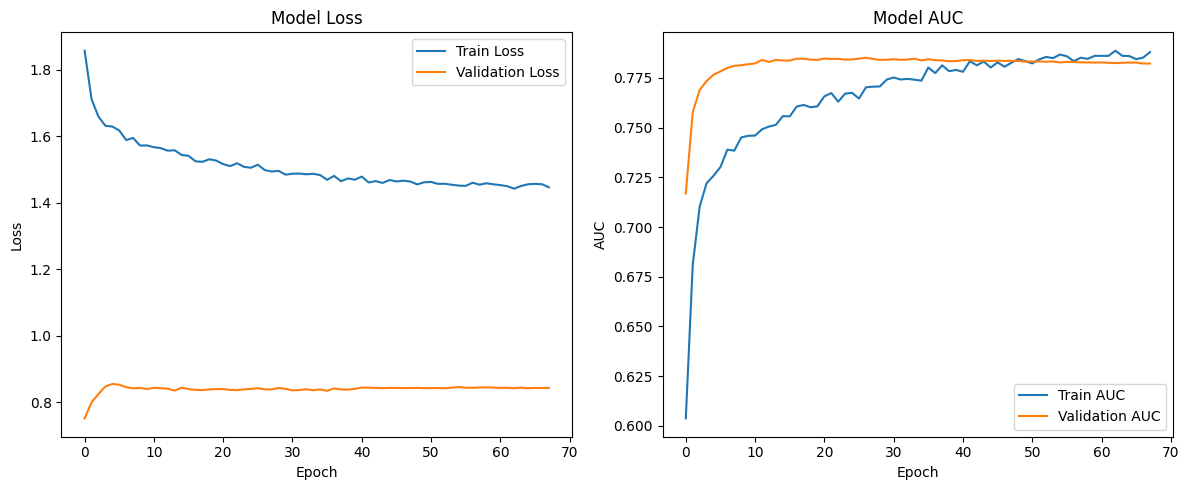

In [11]:
import matplotlib.pyplot as plt
# 9.3 พล็อตกราฟ Training History (Loss)
print("\n--- 9.3: Plotting Training History ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# 9.4 พล็อตกราฟ Training History (AUC)
plt.subplot(1, 2, 2)
plt.plot(hist.history['AUC'], label='Train AUC')
plt.plot(hist.history['val_AUC'], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()